<a href="https://colab.research.google.com/github/afrojaakter/MLAutomatic-Speech-Recognition/blob/main/Audio_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I will work on building a basic speech recognition network that recognizes ten different words. The goal is to train a model that classify a one second audio clip as 'down', 'go', 'lefr', 'no', 'right', 'stop', 'up' and 'yes'.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing
from IPython import display

# Set fixed seed for experimental reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


### Import speech commands dataset
The original dataset consiste of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google. I will use a mini portion of the dataset to save time with data loading. 

In [5]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin = 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
      extract = True,
      cache_dir = '.', 
      cache_subdir = 'data'
  )

In [6]:
#basic stats about the data
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'go' 'up' 'yes' 'left' 'stop' 'down' 'right']


In [8]:
# Extract the audio file into a list and shuffle it
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:', 
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Number of total examples: 8000
Number of examples per label: 1000


In [17]:
#Split the files into training, validation and test sets using a 80:10:10 ratio respectively
train_files = filenames[:6400] 
val_files = filenames[6400: 6400 + 800] 
test_files = filenames[-800:]

print('Trainin set size {} \nValidation set size {} \nTest set size {}'
 .format(len(train_files), len(val_files), len(test_files)))

Trainin set size 6400 
Validation set size 800 
Test set size 800


### Readin audio files and their labels
The audio file will initially be read as a binary file, which we will convert into a numerical tensor.

To load the aufio file, I will use ```tf.audi.decode_wav```, which returns the WAV-encoded audio as a Tensor and the sample rate. It also normalize the values to the range [-1.0, 1.0].

A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in ```mini_speech_commands```, the values range from -32768 to 32768. The sample rate for this dataset is 16kHz. 

In [22]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  '''return the label for each WAV file is its parent direcotry'''
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

def get_waveform_and_lable(file_path):
  '''Takes input th eflename of the WAV file and 
  returns a tuple containing the audio and labels for supervised training'''
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [23]:
Autotune = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_lable, 
                           num_parallel_calls=Autotune)

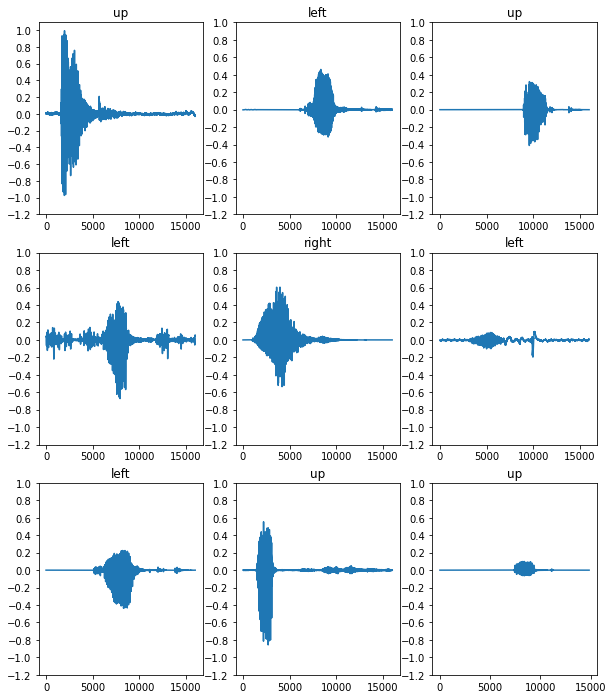

In [31]:
# examine few audio waveforms with their corresponding labels
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols 
  c = i % cols 
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Spectrogram
Now we will convert the waveform into a spectrogram, which shows frequency changes over time and can be the represented as a 2D image. This can ne done by applying the short-time Fourier Transform (STFT) to conver the audio into the time-frequency domain.

A Fourier transorm (```tf.signal.fft```) converts a singal to its component frequencies, but loses all time information. The STFT(```tf.signal.stft```) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that we can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and pahse. However, we'll only need the magniture for this project, which can be drived by applying ```tf.abs``` on the output of ```tf.siganl.stft```. 

We want to choose ```frame_length``` and ```frame_step``` parameters such that the generated spectrogram 'image' is almost square.

We also want the waveforms to have the same lenght, so that when we convert it to a spectorgram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second. 



In [37]:
def get_spectrogram(waveform):
  #Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32) 

  #Concatenate audio with padding so that all audio clips will be
  # of the same lenth
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  return spectrogram

# Explore the data. Compare the waveform, the spectrogram and the
# actual audio of one example from the dataset
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf=8')
  spectrogram = get_spectrogram(waveform)

print('Label: {}\nWaveform shape: {}\nSpectrogram shape: {}'
.format(label, waveform.shape, spectrogram.shape))
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback
